In [1]:
#KERAS METADATOS

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import ResNet50V2

tf.__version__

'2.5.0'

In [3]:
!git clone https://github.com/CartagenaMinas/Melanomas.git

Cloning into 'Melanomas'...
remote: Enumerating objects: 43614, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 43614 (delta 5), reused 7 (delta 3), pack-reused 43603
Receiving objects: 100% (43614/43614), 220.42 MiB | 32.36 MiB/s, done.
Resolving deltas: 100% (8/8), done.
Checking out files: 100% (44121/44121), done.


In [4]:
import os
os.listdir("Melanomas")

['.git', 'Keras_baseline.ipynb', 'data', 'exploracion.ipynb']

In [5]:
PATH="Melanomas/data"
os.listdir(PATH)

['train_clean_split.csv',
 'test_clean.csv',
 'test.csv',
 'val_clean_split.csv',
 'subset_clean.csv',
 'train_clean.csv',
 'val_split.csv',
 'train_split.csv',
 'train.csv',
 'jpeg224',
 'sample_submission.csv',
 'subset.csv']

In [6]:
import pandas as pd
train=pd.read_csv(f"{PATH}/train_clean.csv")
train.shape

(33126, 8)

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33126 entries, 0 to 33125
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   image_name                     33126 non-null  object
 1   patient_id                     33126 non-null  object
 2   sex                            33126 non-null  object
 3   age_approx                     33126 non-null  object
 4   anatom_site_general_challenge  33126 non-null  object
 5   diagnosis                      33126 non-null  object
 6   benign_malignant               33126 non-null  object
 7   target                         33126 non-null  int64 
dtypes: int64(1), object(7)
memory usage: 2.0+ MB


In [8]:
train.isna().sum()

image_name                       0
patient_id                       0
sex                              0
age_approx                       0
anatom_site_general_challenge    0
diagnosis                        0
benign_malignant                 0
target                           0
dtype: int64

In [9]:
train.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [10]:
from sklearn.preprocessing import OneHotEncoder

oh_encoder=OneHotEncoder()
cols=["sex","age_approx","anatom_site_general_challenge"]
oh_encoder.fit(train[cols])
oh_encoder.categories_

[array(['female', 'male', 'unk'], dtype=object),
 array(['0.0', '10.0', '15.0', '20.0', '25.0', '30.0', '35.0', '40.0',
        '45.0', '50.0', '55.0', '60.0', '65.0', '70.0', '75.0', '80.0',
        '85.0', '90.0', 'unk'], dtype=object),
 array(['head/neck', 'lower extremity', 'oral/genital', 'palms/soles',
        'torso', 'unk', 'upper extremity'], dtype=object)]

In [11]:
#train=pd.read_csv(f"{PATH}/train_clean_split.csv")
train=pd.read_csv(f"{PATH}/subset_clean.csv")
val=pd.read_csv(f"{PATH}/val_clean_split.csv")
train.shape,val.shape

((2220, 8), (10932, 8))

In [12]:
BATCH_SIZE=64
AUTO=tf.data.experimental.AUTOTUNE

def decode(name,meta,label):
  img=tf.io.read_file(name)#lo lee en byts
  img=tf.image.decode_jpeg(img,channels=3)#lo carga como imagen
  img=tf.cast(img,tf.float32)#/255#cambia la presicion
  return img,meta,label


def augment(img,meta,label):
  #augmentation
  img=tf.image.random_flip_left_right(img)
  img=tf.image.random_flip_up_down(img)
  return (img, meta),label


def load_ds(df):
  options=tf.data.Options()
  options.experimental_deterministic=False#Para que lo cargue en orden aleatorio
  imgs, labels=df["image_name"].values,df["target"].values#Creo una lista 
  meta=df[cols]
  meta=oh_encoder.transform(meta).toarray()
  imgs=[f"{PATH}/jpeg224/train/{name}.jpg" for name in imgs]#Creo una lista con mis rutas
  ds=tf.data.Dataset.from_tensor_slices((imgs,meta,labels))
  ds=ds.with_options(options)
  ds=ds.map(decode,num_parallel_calls=AUTO)#uso todos los procesadores
  #ds=ds.cache()#Guarda la imagen en memoria, lo puedo usar si tengo mucha ram
  ds=ds.map(augment,num_parallel_calls=AUTO)
  ds=ds.shuffle(2048)
  ds=ds.batch(BATCH_SIZE)
  ds=ds.prefetch(buffer_size=AUTO) #Mientras la gpu calcula la cpu carga imagenes
  return ds



In [13]:
train_ds=load_ds(train)
val_ds=load_ds(val)

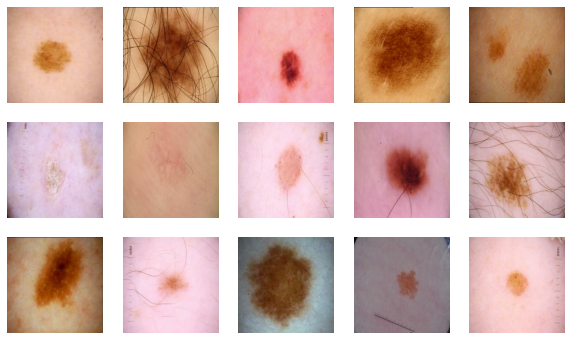

In [14]:
import matplotlib.pyplot as plt
import random
r,c=3,5
fig=plt.figure(figsize=(2*c,2*r))
for _r in range (r):
  for _c in range (c):
    plt.subplot(r,c,_r*c+_c+1)
    for data, labels in train_ds.take(1):
      imgs,meta=data
      img=imgs[0].numpy()/255
      plt.imshow(img)
      plt.axis(False)
plt.show()

In [15]:
IMAGE_SIZE= (224,224,3)

encoder=ResNet50V2(
    include_top=False,
    input_shape=IMAGE_SIZE,
    weights="imagenet"
)
encoder.trainable=False #No aplicar los gradientes calculados

imgs=keras.Input(shape=IMAGE_SIZE, name="image")
x=keras.layers.experimental.preprocessing.Rescaling(1./255)(imgs)
x=encoder(x,training=False)#No calcula los gradientes
x=keras.layers.GlobalAveragePooling2D()(x)

metadata=keras.Input(shape=(29,), name="metadata")
y=keras.layers.Dense(100, activation="relu")(metadata)
y=keras.layers.Dense(3, activation="relu")(y)

z=keras.layers.concatenate([x,y])
outputs=keras.layers.Dense(1,activation="sigmoid")(z)

model=keras.Model(inputs=[imgs,metadata],outputs=outputs)
model.summary()

94674944/94668760 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           image[0][0]                      
__________________________________________________________________________________________________
metadata (InputLayer)           [(None, 29)]         0                                            
__________________________________________________________________________________________________
resnet50v2 (Functional)         (None, 7, 7, 2048)   23564800    rescaling[0][0]                  
_____________________________

In [16]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.AUC(name="auc")]
)

In [17]:
filepath="./checkpoints/checkpoint"
cb=tf.keras.callbacks.ModelCheckpoint(
    filepath=filepath,
    monitor="val_auc",
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode="max"
)

In [18]:
model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    validation_steps=10,
    callbacks=[cb])

Epoch 1/10
35/35 [==============================] - 47s 324ms/step - loss: 0.2374 - auc: 0.4980 - val_loss: 0.1798 - val_auc: 0.3091

Epoch 00001: val_auc improved from -inf to 0.30908, saving model to ./checkpoints/checkpoint
Epoch 2/10
35/35 [==============================] - 11s 268ms/step - loss: 0.1072 - auc: 0.4658 - val_loss: 0.1806 - val_auc: 0.4490

Epoch 00002: val_auc improved from 0.30908 to 0.44900, saving model to ./checkpoints/checkpoint
Epoch 3/10
35/35 [==============================] - 11s 268ms/step - loss: 0.0930 - auc: 0.5557 - val_loss: 0.1108 - val_auc: 0.6001

Epoch 00003: val_auc improved from 0.44900 to 0.60013, saving model to ./checkpoints/checkpoint
Epoch 4/10
35/35 [==============================] - 11s 267ms/step - loss: 0.0857 - auc: 0.6573 - val_loss: 0.1013 - val_auc: 0.6033

Epoch 00004: val_auc improved from 0.60013 to 0.60330, saving model to ./checkpoints/checkpoint
Epoch 5/10
35/35 [==============================] - 11s 268ms/step - loss: 0.0798 -

In [20]:
#Cargar los Pesos
model.load_weights(filepath)
model.save("model.h5")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [21]:
model.evaluate(val_ds)

171/171 [==============================] - 33s 185ms/step - loss: 0.0777 - auc: 0.7852


[0.07771298289299011, 0.7852170467376709]

In [25]:
test=pd.read_csv(f"{PATH}/test_clean.csv")
test["age_approx"]=test["age_approx"].astype(str)
test.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,unk
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


In [26]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10982 entries, 0 to 10981
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   image_name                     10982 non-null  object
 1   patient_id                     10982 non-null  object
 2   sex                            10982 non-null  object
 3   age_approx                     10982 non-null  object
 4   anatom_site_general_challenge  10982 non-null  object
dtypes: object(5)
memory usage: 429.1+ KB


In [27]:
BATCH_SIZE=256

def decode_test(name,meta):
  img=tf.io.read_file(name)#lo lee en byts
  img=tf.image.decode_jpeg(img,channels=3)#lo carga como imagen
  img=tf.cast(img,tf.float32)#/255#cambia la presicion
  return {"image":img, "metadata":meta}

def load_test_ds(df):
  imgs=df["image_name"].values#Creo una lista 
  imgs=[f"{PATH}/jpeg224/test/{name}.jpg" for name in imgs]#Creo una lista con mis rutas
  meta=df[cols]
  meta=oh_encoder.transform(meta).toarray()
  ds=tf.data.Dataset.from_tensor_slices((imgs,meta))
  ds=ds.map(decode_test)
  ds=ds.batch(BATCH_SIZE)
  return ds

In [28]:
test_ds=load_test_ds(test)

In [29]:
preds=model.predict(test_ds)

In [30]:
preds

array([[0.0161236 ],
       [0.00382335],
       [0.0168169 ],
       ...,
       [0.11163541],
       [0.00459823],
       [0.02806343]], dtype=float32)

In [31]:
submission=pd.DataFrame({
    "image_name":test["image_name"].values,"target":preds.ravel()
})
submission.head()

,image_name,target
0,ISIC_0052060,0.016124
1,ISIC_0052349,0.003823
2,ISIC_0058510,0.016817
3,ISIC_0073313,0.000813
4,ISIC_0073502,0.012390


In [33]:
submission.to_csv("sumissionMETA.csv",index=False)